In [51]:
import numpy as np
import pandas as pd
import sys

path='/home/jbohn/jupyter/personal/Kernel_Learning/'
sys.path.append(path)

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from Features.clean_data import clean_quotes
from Features.feature_preprocessing import generate_features_from_quotes
from LOB_Analysis.batch_data import batch_solve_mkl, batch_features
from LOB_Analysis.batch_kernel import train_svm_batch, predict_svm_batch



### Fetch Raw Quote Data

- Quotes for AAPL across 13 exchanges that offer U.S. equities
- Data corresponds to Jan 2020

In [52]:
quotes=pd.read_csv(path+'data/AAPL_quotes.csv')
quotes

/tmp/ipykernel_5805/1904343625.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  quotes=pd.read_csv(path+'data/AAPL_quotes.csv')


,Time,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,FINRA_BBO_Indicator,...,Best_Offer_Size,Best_Offer_FINRA_Market_Maker_ID,LULD_Indicator,LULD_NBBO_Indicator,SIP_Generated_Message_Identifier,Participant_Timestamp,FINRA_ADF_Timestamp,Security_Status_Indicator,Quote_Cancel_Correction,National_BBO_Ind
0,2020-01-02 04:00:00.065165,P,AAPL,278.00,7.0,0.00,0.0,R,2228,NaN,...,0.0,NaN,NaN,NaN,NaN,40000064785664,NaN,,NaN,2
1,2020-01-02 04:00:00.065167,P,AAPL,278.00,14.0,0.00,0.0,R,2229,NaN,...,0.0,NaN,NaN,NaN,NaN,40000064787456,NaN,,NaN,2
2,2020-01-02 04:00:00.065170,P,AAPL,293.72,9.0,0.00,0.0,R,2230,NaN,...,0.0,NaN,NaN,NaN,NaN,40000064790784,NaN,,NaN,2
3,2020-01-02 04:00:32.677788,P,AAPL,295.08,10.0,295.81,1.0,R,2676,NaN,...,1.0,NaN,NaN,NaN,NaN,40032677415424,NaN,,NaN,2
4,2020-01-02 04:00:36.260761,Q,AAPL,295.02,4.0,300.00,1.0,R,2696,NaN,...,1.0,NaN,NaN,NaN,NaN,40036260727444,NaN,,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2925268,2020-01-09 19:59:47.657672,K,AAPL,310.38,20.0,310.40,7.0,R,33431302,NaN,...,151.0,NaN,NaN,NaN,NaN,195947657433000,NaN,,NaN,2
2925269,2020-01-09 19:59:48.734101,Q,AAPL,310.25,1.0,310.40,141.0,R,33431303,NaN,...,141.0,NaN,NaN,NaN,NaN,195948734083107,NaN,,NaN,2
2925270,2020-01-09 19:59:50.192454,K,AAPL,310.38,21.0,310.40,7.0,R,33431396,NaN,...,141.0,NaN,NaN,NaN,NaN,195950192198000,NaN,,NaN,2
2925271,2020-01-09 19:59:53.972452,Q,AAPL,310.25,1.0,310.40,140.0,R,33431420,NaN,...,140.0,NaN,NaN,NaN,NaN,195953972434327,NaN,,NaN,2


### Clean & Preprocessing

- Drops market quotes outside of open hours
- Criteria for invalid quotes (inverted spread, zero price or volume)
- Standardizes Participant Timestamp as time index

In [53]:
quotes=quotes[quotes['Time']<'2020-01-04']
cleaned_quotes=clean_quotes(quotes)
cleaned_quotes

/home/jbohn/jupyter/personal/Kernel_Learning/Features/clean_data.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quotes["date"] = quotes["Time"].apply(lambda x: str(x[:11]))


,SIP_Timestamp,Exchange,Symbol,Bid_Price,Bid_Size,Offer_Price,Offer_Size,Quote_Condition,Sequence_Number,Source_Of_Quote,...,Best_Bid_Price,Best_Bid_Size,Best_Offer_Exchange,Best_Offer_Price,Best_Offer_Size,LULD_NBBO_Indicator,SIP_Generated_Message_Identifier,Security_Status_Indicator,National_BBO_Ind,date
2020-01-02 09:30:00.134062,2020-01-02 09:30:00.134429,P,AAPL,296.09,1.0,296.29,1.0,R,262393,N,...,296.24,2.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.134336,2020-01-02 09:30:00.134554,K,AAPL,296.21,1.0,296.39,1.0,R,262394,N,...,296.21,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.134532,2020-01-02 09:30:00.134742,K,AAPL,296.10,1.0,296.36,2.0,R,262401,N,...,296.10,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.136081,2020-01-02 09:30:00.136273,K,AAPL,296.10,1.0,296.29,1.0,R,262424,N,...,296.10,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
2020-01-02 09:30:00.234474,2020-01-02 09:30:00.234700,K,AAPL,296.11,1.0,296.39,1.0,R,263840,N,...,296.11,1.0,P,296.29,1.0,NaN,NaN,,2,2020-01-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-03 19:58:06.821466,2020-01-03 19:58:06.821713,K,AAPL,297.32,6.0,297.39,1.0,R,32867875,N,...,297.33,1.0,K,297.39,1.0,NaN,NaN,,2,2020-01-03
2020-01-03 19:58:52.244692,2020-01-03 19:58:52.244711,Q,AAPL,297.35,1.0,297.65,1.0,R,32867910,N,...,297.35,1.0,K,297.40,2.0,NaN,NaN,,2,2020-01-03
2020-01-03 19:59:05.755719,2020-01-03 19:59:05.755739,Q,AAPL,297.15,3.0,297.65,1.0,R,32867920,N,...,297.34,3.0,K,297.40,2.0,NaN,NaN,,2,2020-01-03
2020-01-03 19:59:44.592952,2020-01-03 19:59:44.593332,P,AAPL,297.30,10.0,297.33,1.0,R,32867961,N,...,297.32,6.0,P,297.33,1.0,NaN,NaN,,2,2020-01-03


### Feature Generation

- Generates set of features off quote data 
- Performs time aggregation to 5 second 
- Labels outcome; price direction relative to next interval

In [4]:
### paul : more features in generate_features_from_quotes

In [54]:
labelled_data=generate_features_from_quotes(cleaned_quotes,time_agg=5,save=True)
labelled_data

In [ ]:
labelled_data=pd.read_csv(path+'data/labeled_data.csv',index_col=0)

In [ ]:
features=labelled_data[['FB0','FA0','FB2','FA2']]
outcomes=labelled_data['outcome']

features

,FB0,FA0,FB2,FA2
last_interval,,,,
2020-01-02 09:30:00,1.0,1.0,-1.0,0.0
2020-01-02 09:30:05,26.0,2.0,-3.0,-1.0
2020-01-02 09:30:10,2.0,2.0,0.0,1.0
2020-01-02 09:30:15,1.0,1.0,0.0,0.0
2020-01-02 09:30:20,1.0,1.0,0.0,0.0
...,...,...,...,...
2020-01-02 15:59:35,3.0,92.0,0.0,-3.0
2020-01-02 15:59:40,3.0,3.0,1.0,1.0
2020-01-02 15:59:45,2.0,1.0,1.0,-3.0


### Batch Features

- For computational feasiblity will retrain model off batched data looking to evaluate performance in subsequent interval
- Batches features and outcomes in size batch_size which model will be trained from

In [ ]:
batch_size=60

batch_data=batch_features(features,outcomes,batch_size)
batch_data

{0.0: {'last_interval': '2020-01-02 09:30:00',
  'features':                       FB0   FA0   FB2  FA2
  last_interval                             
  2020-01-02 09:30:00   1.0   1.0  -1.0  0.0
  2020-01-02 09:30:05  26.0   2.0  -3.0 -1.0
  2020-01-02 09:30:10   2.0   2.0   0.0  1.0
  2020-01-02 09:30:15   1.0   1.0   0.0  0.0
  2020-01-02 09:30:20   1.0   1.0   0.0  0.0
  2020-01-02 09:30:25   1.0   8.0   0.0  1.0
  2020-01-02 09:30:30   1.0   9.0  -2.0 -1.0
  2020-01-02 09:30:35   1.0   2.0  -2.0  0.0
  2020-01-02 09:30:40   1.0   2.0  -1.0  0.0
  2020-01-02 09:30:45   1.0   2.0   0.0  0.0
  2020-01-02 09:30:50   4.0   2.0   0.0  0.0
  2020-01-02 09:30:55  10.0   2.0  -2.0  0.0
  2020-01-02 09:31:00   1.0   2.0   0.0  0.0
  2020-01-02 09:31:05   3.0   1.0   0.0 -1.0
  2020-01-02 09:31:10   3.0   3.0   1.0  0.0
  2020-01-02 09:31:15   2.0   1.0   0.0  0.0
  2020-01-02 09:31:20   7.0   1.0   2.0 -1.0
  2020-01-02 09:31:25   3.0   2.0   0.0  1.0
  2020-01-02 09:31:30   3.0   2.0   0.0  

### Train Single Kernel across batched dataset

In [ ]:
#### Jarryd : single kernel training functionality in Kernels/single_kernel.py

### MKL Training across batched data 


In [ ]:
batched_estimates=batch_solve_mkl(features,outcomes,5,60,'gaussian',5,verbose=False)

Batch  0 Last Interval 2020-01-02 09:30:00 complete with weights  [0.         0.22229447 0.24515288 0.2607298  0.27182286]
Batch  60 Last Interval 2020-01-02 09:35:00 complete with weights  [0.         0.21287385 0.24389797 0.26430208 0.2789261 ]
Batch  120 Last Interval 2020-01-02 09:40:00 complete with weights  [0.         0.22631928 0.24537654 0.25900251 0.26930168]
Batch  180 Last Interval 2020-01-02 09:45:00 complete with weights  [0.         0.22767894 0.24405337 0.25813374 0.27013395]
Batch  240 Last Interval 2020-01-02 09:50:00 complete with weights  [0.         0.22644683 0.24514068 0.25879005 0.26962244]
Batch  300 Last Interval 2020-01-02 09:55:00 complete with weights  [0.         0.23540437 0.24927602 0.25555003 0.25976958]
Batch  360 Last Interval 2020-01-02 10:00:00 complete with weights  [0.         0.22863644 0.24853897 0.25896766 0.26385693]
Batch  420 Last Interval 2020-01-02 10:05:00 complete with weights  [0.         0.22543448 0.24623337 0.2596042  0.26872795]
Bat

In [ ]:
batch_svm,batch_index=train_svm_batch(batch_data,batched_estimates,'gaussian',5)

In [ ]:
evaluation_dict=predict_svm_batch(batch_svm,batch_index,batch_data,batched_estimates,'gaussian',5)

In [ ]:
evaluation_dict

{'2020-01-02 09:30:00': {'accuracy': 0.3, 'recall': 0.3},
 '2020-01-02 09:35:00': {'accuracy': 0.7166666666666667,
  'recall': 0.7166666666666667},
 '2020-01-02 09:40:00': {'accuracy': 0.26666666666666666,
  'recall': 0.26666666666666666},
 '2020-01-02 09:45:00': {'accuracy': 0.31666666666666665,
  'recall': 0.31666666666666665},
 '2020-01-02 09:50:00': {'accuracy': 0.4, 'recall': 0.4},
 '2020-01-02 09:55:00': {'accuracy': 0.4, 'recall': 0.4},
 '2020-01-02 10:00:00': {'accuracy': 0.35, 'recall': 0.35},
 '2020-01-02 10:05:00': {'accuracy': 0.38333333333333336,
  'recall': 0.38333333333333336},
 '2020-01-02 10:10:00': {'accuracy': 0.36666666666666664,
  'recall': 0.36666666666666664},
 '2020-01-02 10:15:00': {'accuracy': 0.36666666666666664,
  'recall': 0.36666666666666664},
 '2020-01-02 10:20:00': {'accuracy': 0.2833333333333333,
  'recall': 0.2833333333333333},
 '2020-01-02 10:25:00': {'accuracy': 0.4, 'recall': 0.4},
 '2020-01-02 10:30:00': {'accuracy': 0.31666666666666665,
  'recall'

In [ ]:
dts=pd.to_datetime([i for i in evaluation_dict.keys()])
accuracy=np.array([i['accuracy'] for i in evaluation_dict.values()])
recall=np.array([i['recall'] for i in evaluation_dict.values()])

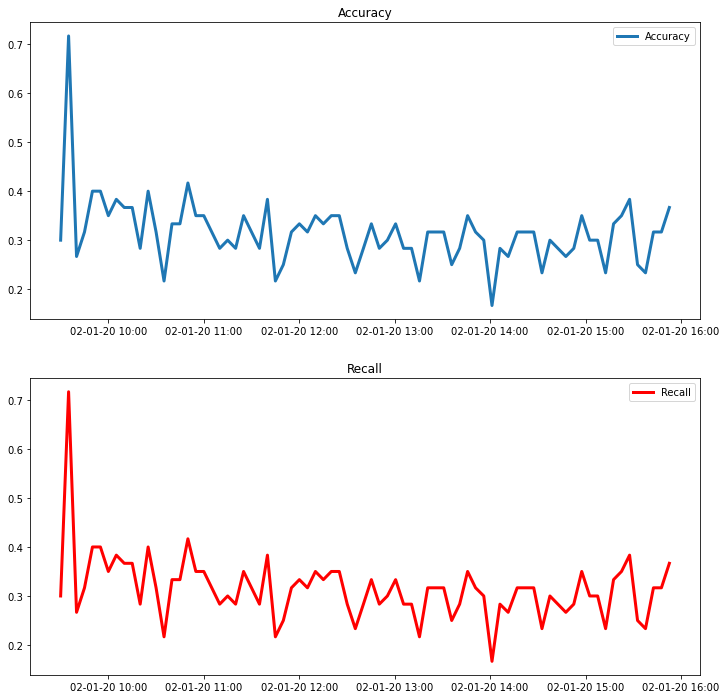

In [ ]:
fig,axis=plt.subplots(2,1,figsize=(12,12))
axis[0].plot(dts,accuracy,lw=3,label='Accuracy')
axis[0].set_title('Accuracy')
axis[1].plot(dts,recall,lw=3,label='Recall',color='red')
axis[1].set_title('Recall')
axis[0].legend()
axis[1].legend()
xfmt = DateFormatter('%d-%m-%y %H:%M')
axis[0].xaxis.set_major_formatter(xfmt)
axis[1].xaxis.set_major_formatter(xfmt)